In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CARUID_csv/BARLEY_1100.csv')

timeline = []
for i in range(0, len(df["Year"])):
  timeline.append(i)

df["Weeks"] = timeline

df.pop("Year")
df.pop("Area")
df.head()

,SumPcpn,SumEGDD_C,SumHeatD,SumFrostD,AvgSI,AvgPrcnAWHC,NDVI,Yield,Weeks
0,16.405556,20.011111,0.0,3.000000,0.563175,0.899921,0.302127,59.1,0
1,10.544444,28.483333,0.0,1.833333,0.563651,0.891667,0.338232,59.1,1
2,10.438889,34.088889,0.0,1.444444,0.588333,0.863810,0.370780,59.1,2
3,13.227778,38.197222,0.0,1.500000,0.603889,0.838889,0.407115,59.1,3
4,27.983333,48.702778,0.0,0.555556,0.569921,0.860476,0.442306,59.1,4


In [ ]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

full_data = df

train

,SumPcpn,SumEGDD_C,SumHeatD,SumFrostD,AvgSI,AvgPrcnAWHC,NDVI,Yield,Weeks
0,16.405556,20.011111,0.0,3.000000,0.563175,0.899921,0.302127,59.1,0
1,10.544444,28.483333,0.0,1.833333,0.563651,0.891667,0.338232,59.1,1
2,10.438889,34.088889,0.0,1.444444,0.588333,0.863810,0.370780,59.1,2
3,13.227778,38.197222,0.0,1.500000,0.603889,0.838889,0.407115,59.1,3
4,27.983333,48.702778,0.0,0.555556,0.569921,0.860476,0.442306,59.1,4
...,...,...,...,...,...,...,...,...,...
576,15.355556,84.747222,0.0,0.000000,0.524048,0.846111,0.479826,66.7,576
577,12.494444,95.000000,0.0,0.000000,0.492460,0.810079,0.508590,66.7,577
578,5.877778,94.027778,0.0,0.000000,0.416270,0.710159,0.534341,66.7,578
579,9.538889,97.869444,0.0,0.000000,0.383889,0.584206,0.561037,66.7,579


In [ ]:
f_columns = ['SumPcpn', 'SumEGDD_C', 'SumHeatD','SumFrostD','AvgSI', 
             'AvgPrcnAWHC','NDVI']

from sklearn.preprocessing import StandardScaler

f_transformer = StandardScaler()
yld_transformer = StandardScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
yld_transformer = yld_transformer.fit(train[['Yield']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Yield'] = yld_transformer.transform(train[['Yield']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Yield'] = yld_transformer.transform(test[['Yield']])



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 19

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Yield, time_steps)
X_test, y_test = create_dataset(test, test.Yield, time_steps)

print(X_train.shape, y_train.shape)

(562, 19, 9) (562,)


In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
16/16 [==============================] - 5s 78ms/step - loss: 1.1882 - val_loss: 1.9424
Epoch 2/30
16/16 [==============================] - 1s 32ms/step - loss: 1.2786 - val_loss: 1.3342
Epoch 3/30
16/16 [==============================] - 0s 31ms/step - loss: 1.1288 - val_loss: 1.6348
Epoch 4/30
16/16 [==============================] - 1s 32ms/step - loss: 1.0556 - val_loss: 1.3695
Epoch 5/30
16/16 [==============================] - 0s 30ms/step - loss: 1.0187 - val_loss: 1.6301
Epoch 6/30
16/16 [==============================] - 1s 31ms/step - loss: 0.9787 - val_loss: 1.3783
Epoch 7/30
16/16 [==============================] - 1s 34ms/step - loss: 0.9461 - val_loss: 1.6766
Epoch 8/30
16/16 [==============================] - 0s 31ms/step - loss: 1.0020 - val_loss: 1.4044
Epoch 9/30
16/16 [==============================] - 0s 31ms/step - loss: 0.9821 - val_loss: 1.5376
Epoch 10/30
16/16 [==============================] - 0s 31ms/step - loss: 0.9316 - val_loss: 1.4515
Epoch 11/

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = yld_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = yld_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = yld_transformer.inverse_transform(y_pred)

In [ ]:
full_data.loc[:, f_columns] = f_transformer.transform(full_data[f_columns].to_numpy())
full_data['Yield'] = yld_transformer.transform(full_data[['Yield']])
X_full_data, y_full_data = create_dataset(full_data, full_data.Yield, time_steps)

df_pred = model.predict(X_full_data)
tf.keras.backend.clear_session()
df_pred_inv = yld_transformer.inverse_transform(df_pred)
df_pred_inv

array([[57.986637],
       [57.60964 ],
       [56.86217 ],
       [56.139416],
       [55.949017],
       [55.92817 ],
       [56.0174  ],
       [56.40864 ],
       [57.37752 ],
       [58.299843],
       [60.425327],
       [58.531487],
       [57.4733  ],
       [58.049797],
       [58.348206],
       [57.92365 ],
       [57.92365 ],
       [58.054256],
       [58.054337],
       [58.054337],
       [58.054337],
       [58.054337],
       [58.054337],
       [57.923733],
       [57.92373 ],
       [57.923565],
       [57.914528],
       [57.904316],
       [55.861515],
       [54.706432],
       [52.23998 ],
       [53.08462 ],
       [56.1809  ],
       [53.813305],
       [53.18126 ],
       [53.074806],
       [53.245262],
       [53.961414],
       [54.68003 ],
       [53.96098 ],
       [53.241985],
       [53.05094 ],
       [53.022163],
       [53.02193 ],
       [53.05351 ],
       [53.260754],
       [52.725758],
       [63.42663 ],
       [59.212093],
       [60.599075],


In [ ]:
df_pred_inv

array([[48.570526],
       [50.667118],
       [50.585392],
       [50.572918],
       [50.13237 ],
       [50.122612],
       [50.533447],
       [50.64441 ],
       [49.608086],
       [47.92795 ],
       [46.161297],
       [45.4587  ],
       [45.684315],
       [46.26265 ],
       [47.769276],
       [48.382835],
       [49.97987 ],
       [52.221447],
       [54.80074 ],
       [55.882328],
       [59.19053 ],
       [59.14816 ],
       [58.682648],
       [59.68366 ],
       [59.869987],
       [60.170902],
       [59.447144],
       [59.19368 ],
       [58.605164],
       [57.325974],
       [57.01112 ],
       [57.336628],
       [57.55336 ],
       [58.00614 ],
       [57.42515 ],
       [57.635834],
       [57.953854],
       [57.896935],
       [55.193626],
       [57.38182 ],
       [57.447666],
       [57.3688  ],
       [57.295475],
       [57.213314],
       [57.043278],
       [56.703663],
       [56.484512],
       [56.34164 ],
       [58.13133 ],
       [57.54014 ],


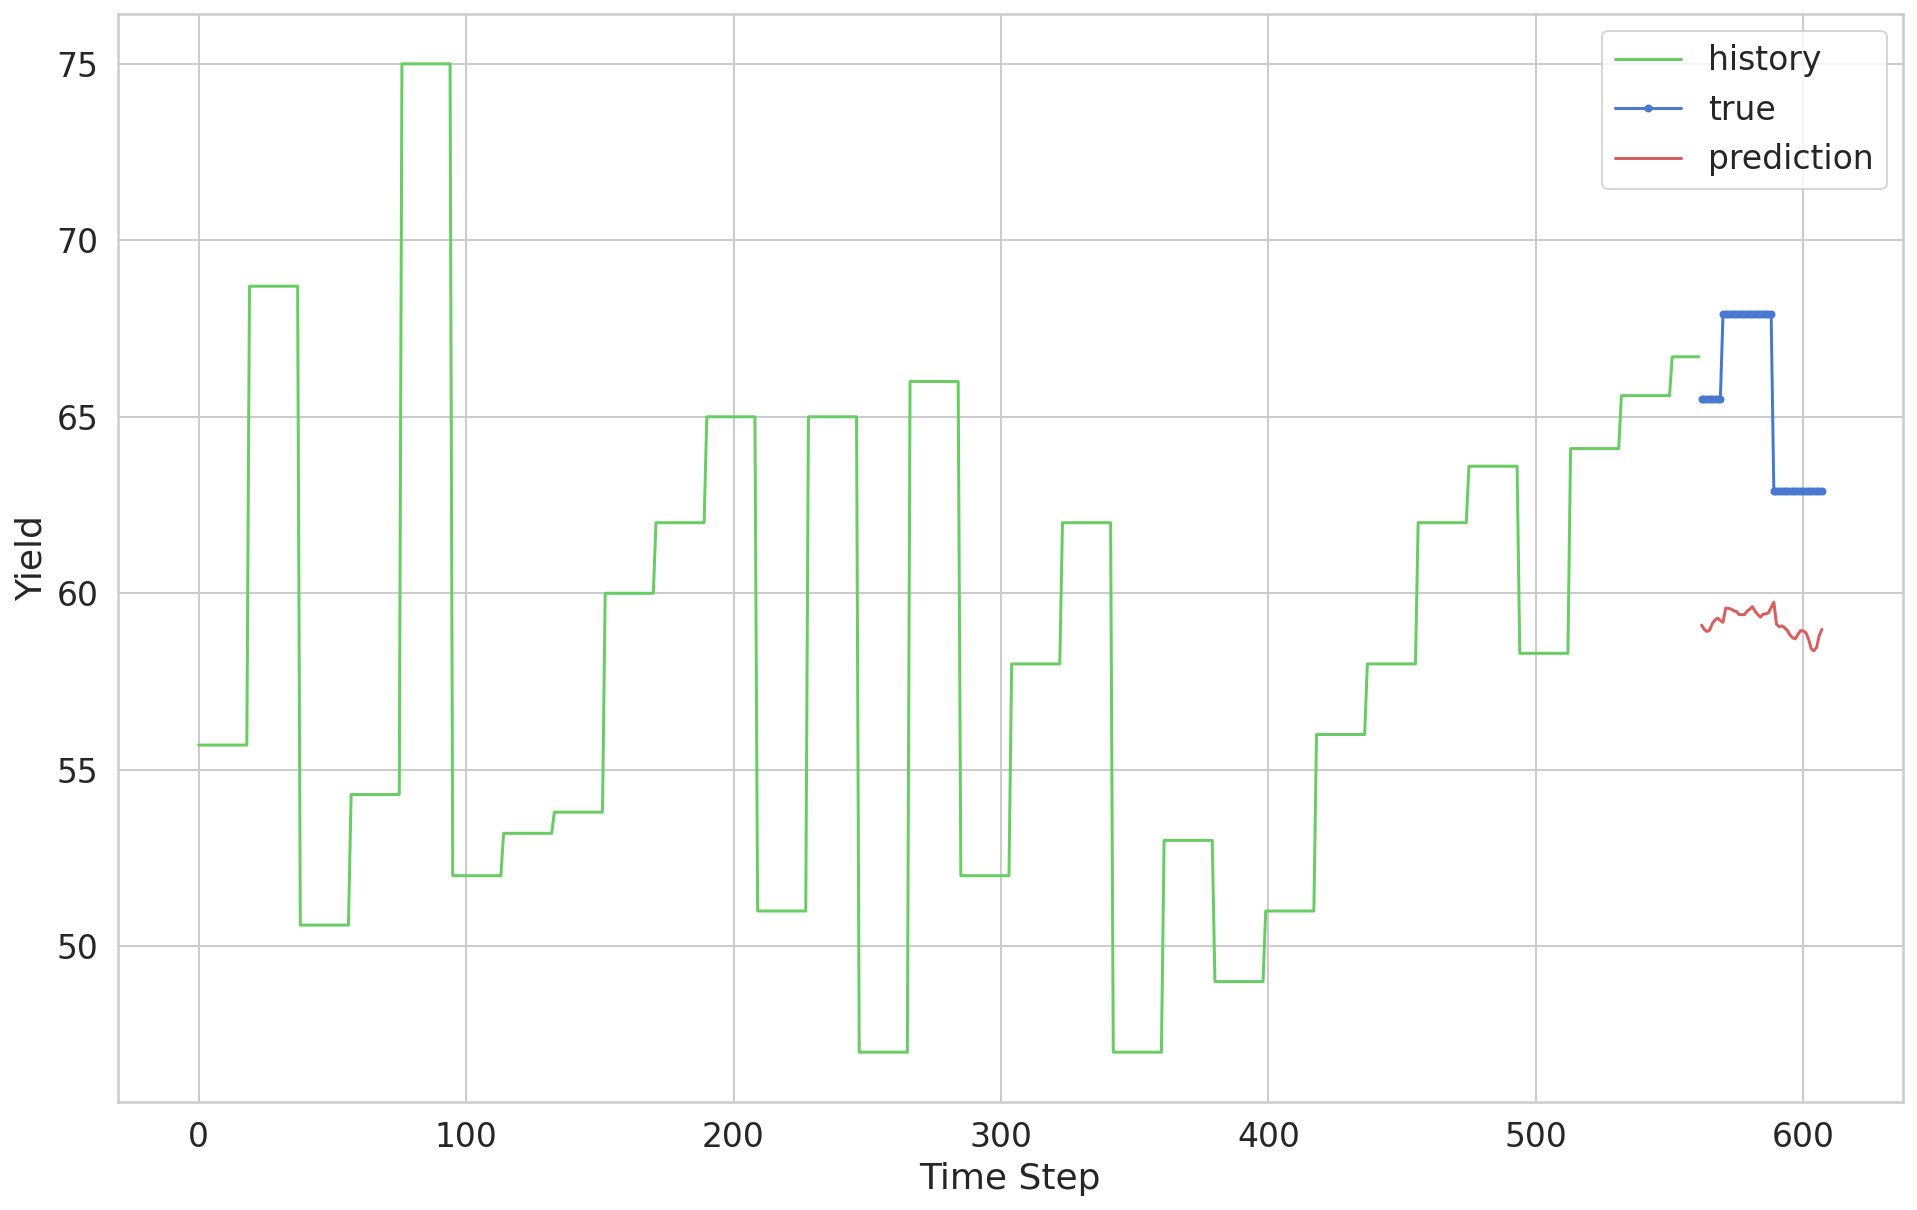

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Yield')
plt.xlabel('Time Step')
plt.legend()
plt.show();